In [1]:
# Import libraries
from __future__ import print_function
import numpy as np
import math
from math import ceil
import tensorflow as tf
import os   
import seaborn as sns
import matplotlib.pyplot as plt  # library for ploting math functions
import pandas as pd
import tensorflow.keras   # Import keras framework with various functions, models and structures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import pathlib
from itertools import chain

# Set parameters for plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.2.0


## Data
Used dataset: https://www.kaggle.com/ayuraj/asl-dataset \
Dataset was devided into 3 catalogs - test, train and val. \
Predicted classes are numbers (0-9).

In [2]:
train_data_dir = pathlib.Path('./american_sign_language/train/')
train_image_count = len(list(train_data_dir.glob('*/*.jpeg')))
train_image_count

490

In [3]:
test_data_dir = pathlib.Path('./american_sign_language/test/')
test_image_count = len(list(test_data_dir.glob('*/*.jpeg')))
test_image_count

140

In [4]:
val_data_dir = pathlib.Path('./american_sign_language/val/')
val_image_count = len(list(val_data_dir.glob('*/*.jpeg')))
val_image_count

70

In [5]:
class_names = np.array([item.name for item in train_data_dir.glob('*') if not item.name.startswith('.')])
num_classes = len(class_names)
class_names

array(['7', '8', '5', '6', '9', '0', '2', '4', '3', '1'], dtype='<U1')

In [6]:
BATCH_SIZE = 32

def calc_steps_per_epoch(image_count):
    return np.ceil(image_count / BATCH_SIZE)

IMG_HEIGHT = 224
IMG_WIDTH = 224
TRAIN_STEPS_PER_EPOCH = calc_steps_per_epoch(train_image_count)
VAL_STEPS_PER_EPOCH = calc_steps_per_epoch(val_image_count)
TEST_STEPS_PER_EPOCH = calc_steps_per_epoch(test_image_count)
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
mask_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [8]:
train_data_gen = mask_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))
train_data_gen = chain(train_data_gen, image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names)))

Found 490 images belonging to 10 classes.
Found 490 images belonging to 10 classes.


In [37]:
test_data_gen = image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 140 images belonging to 10 classes.


In [10]:
val_data_gen = image_generator.flow_from_directory(directory=str(val_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 70 images belonging to 10 classes.


In [11]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(16,16))
  for n in range(32):
      ax = plt.subplot(8, 4,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]==1][0].title())
      plt.axis('off')

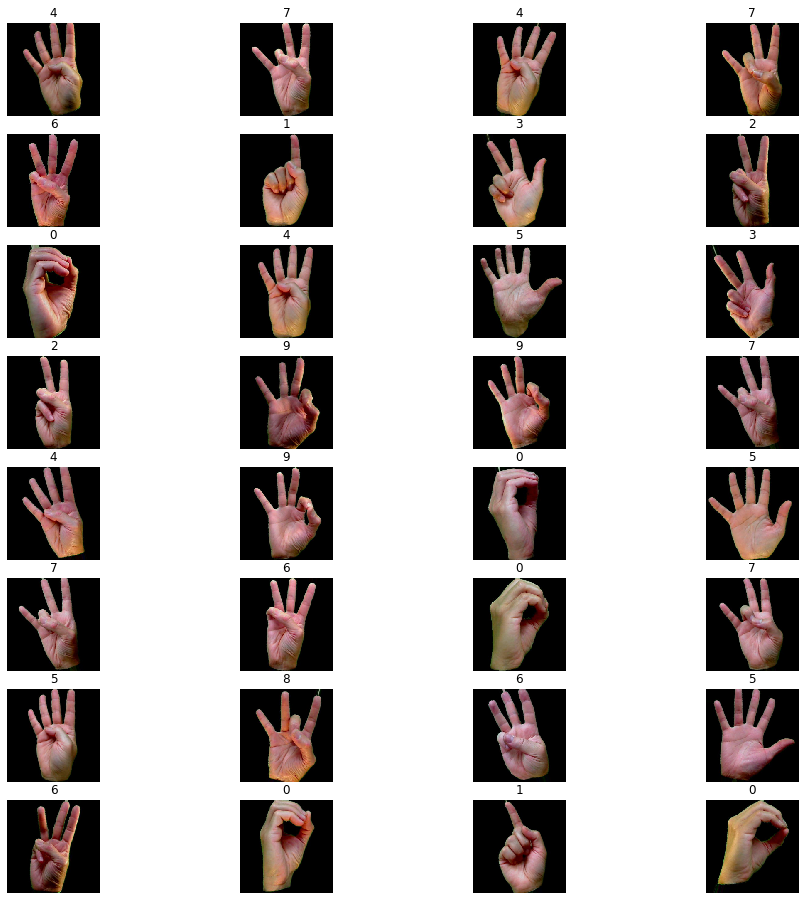

In [12]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [13]:
# Define the sequential Keras model composed of a few layers
model = Sequential()   # establishes the type of the network model
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling2D pools the max value from the frame (sliding window) of 2 x 2 size
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15)) # Implements the drop out with the probability of 0.15
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
# Finish the convolutional model and flatten the layer which does not affect the batch size.
model.add(Flatten())
# Use a dense layer (MLP) consisting of 256 neurons with relu activation functions
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(num_classes, activation='softmax'))

In [14]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['acc'])

In [15]:
epochs = 50

history = model.fit(train_data_gen,
                              epochs=epochs,
                              steps_per_epoch=2 * TRAIN_STEPS_PER_EPOCH,  # no of mini-batches 
                              validation_data=val_data_gen,
                                validation_steps=np.ceil(70/BATCH_SIZE),
                              verbose=1)

Epoch 1/50
32/32 [==============================] - 28s 887ms/step - loss: 2.2957 - acc: 0.1255 - val_loss: 2.2907 - val_acc: 0.1571
Epoch 2/50
32/32 [==============================] - 19s 593ms/step - loss: 2.2820 - acc: 0.1847 - val_loss: 2.2765 - val_acc: 0.1857
Epoch 3/50
32/32 [==============================] - 19s 594ms/step - loss: 2.2662 - acc: 0.2286 - val_loss: 2.2652 - val_acc: 0.2429
Epoch 4/50
32/32 [==============================] - 19s 596ms/step - loss: 2.2463 - acc: 0.2255 - val_loss: 2.2468 - val_acc: 0.2429
Epoch 5/50
32/32 [==============================] - 19s 598ms/step - loss: 2.2165 - acc: 0.2939 - val_loss: 2.2311 - val_acc: 0.1714
Epoch 6/50
32/32 [==============================] - 19s 597ms/step - loss: 2.1867 - acc: 0.2857 - val_loss: 2.2032 - val_acc: 0.3143
Epoch 7/50
32/32 [==============================] - 19s 600ms/step - loss: 2.1492 - acc: 0.3561 - val_loss: 2.1606 - val_acc: 0.4286
Epoch 8/50
32/32 [==============================] - 19s 599ms/step - 

5/5 [==============================] - 1s 133ms/step - loss: 0.5376 - acc: 0.8071
Test loss: 0.5375513434410095
Test accuracy: 0.8071428537368774


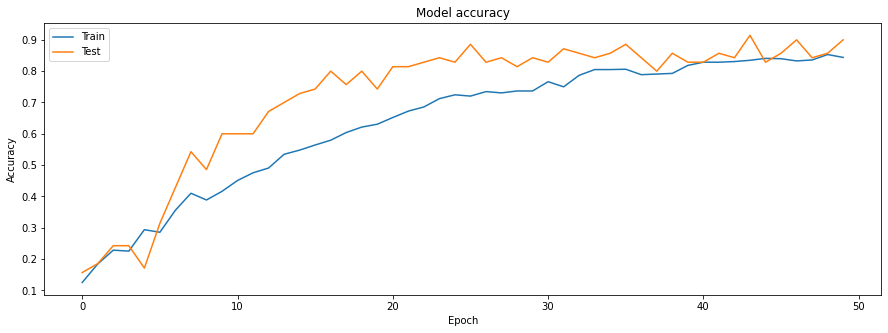

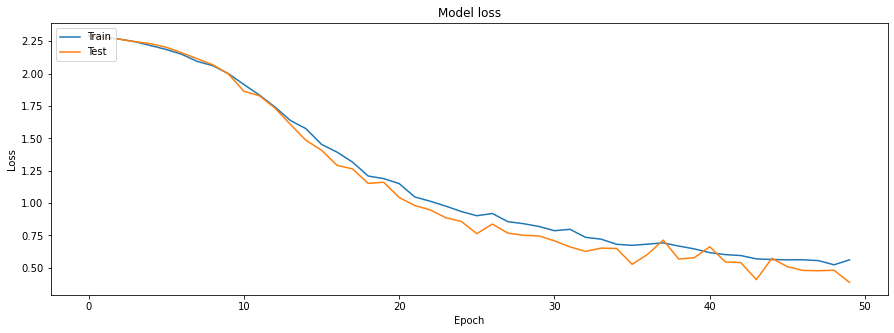

In [110]:
score = model.evaluate_generator(test_data_gen, verbose=1, steps=np.ceil(140/BATCH_SIZE) )
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values: https://keras.io/visualization/#training-history-visualizatio
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [111]:
test_data = np.array([data for batch in range(int(TEST_STEPS_PER_EPOCH)) for data in test_data_gen[batch][0]])
labels = [label for batch in range(int(TEST_STEPS_PER_EPOCH)) for label in np.argmax(test_data_gen[batch][1], axis=1)]

y_pred = model.predict(test_data)
y_pred_max = np.argmax(y_pred, axis=1)

Text(0.5, 105.0, 'Predicted label')

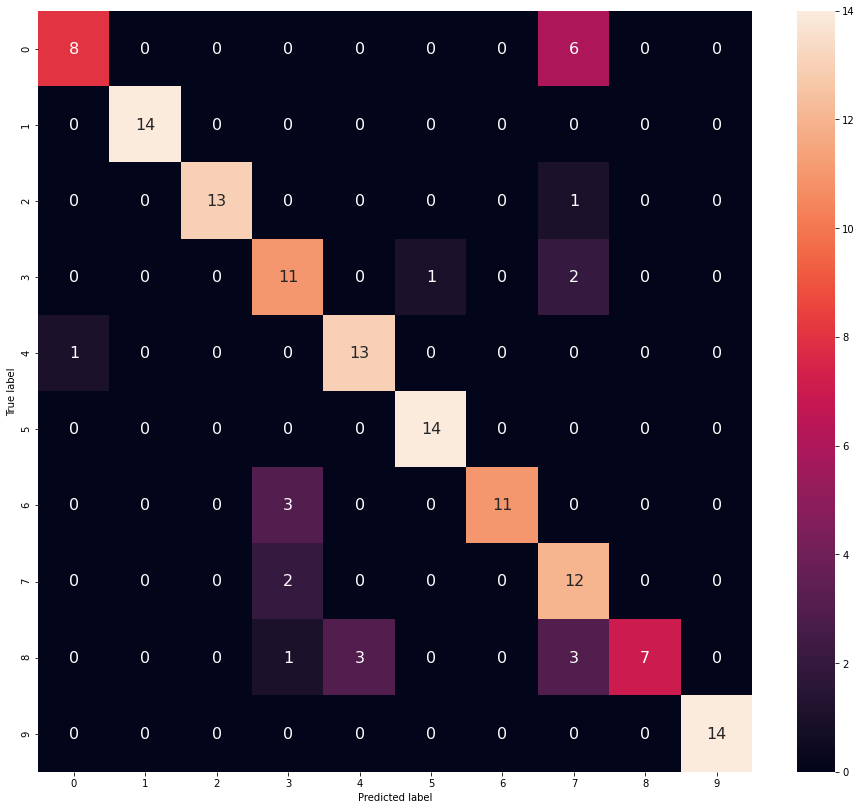

In [112]:
conf_mat = confusion_matrix(labels, y_pred_max)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(16,14))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')